In [126]:
# set plots inline for ipython
%matplotlib inline

# import system & ipython utils
import os
import subprocess
from IPython.display import Image

# numpy and visualization libs
import pandas as pd
import numpy as np
import seaborn as sns

# import data preprocessing, cross validaiton & classifier libs
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.tree import export_graphviz

# performance measures
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss, hamming_loss, mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import matthews_corrcoef, f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score

# set random seed
rand_state = np.random.RandomState(32)

# maps all n x f samples from each participants to a summarized feature vector 
# of size 1 x (f * summary_dimensions) where summary_dimensions are central tendancy and dispertion metrics
summarize_subjects = False
apply_standard_scaler = True

In [127]:
#set paths to datasets
train_data = 'train_data.txt'
test_data = 'test_data.txt' # entirely disjoint set of subjects

# move to data path relative to the .ipnyb base dir
if os.getcwd().split('/')[-1] != 'pd_msr_data':
    os.chdir('./pd_msr_data')

# set dataset column labels
columns = ['subj_id', 'jitter_local', 'jitter_absolute', 'jitter_rap', 'jitter_ppq5', 'jitter_ddp',
        'shimmer_local', 'shimmer_dB', 'shimmer_apq3', 'shimmer_apq5', 'shimmer_apq11', 'shimmer_dda',
        'AC', 'NTH', 'HTN', 'median_pitch', 'mean_pitch', 'standard_dev', 'min_pitch', 'max_pitch',
        'num_pulses', 'num_periods', 'mean_period', 'standard_dev_period', 'fraction_locally_unvoiced_frames',
        'num_voice_breaks', 'deg_voice_breaks','UPDRS','pd']
    
df = pd.read_csv(train_data)
df.columns = columns

# compute mean and standard deviation of features across subjects
if (summarize_subjects):
    # group subjects and summarize data using central tendancy and dispertion metrics
    target_labels = df.drop_duplicates(['subj_id'])[['subj_id','UPDRS','pd']].set_index('subj_id')
    df_mean = df.drop(['UPDRS','pd'], axis=1).groupby('subj_id').mean()
    df_std = df.drop(['UPDRS','pd'], axis=1).groupby('subj_id').std()
    
    # rename() filters the column labels and concats w/ y if it is a feature
    rename = lambda x,y: x if x in ['UPDRS','pd'] else x + y
    
    # rename column labels to reflect summary operation
    df_mean.columns = [rename(col_name,'_m') for col_name, col in df_mean.transpose().iterrows()]
    df_std.columns = [rename(col_name,'_s') for col_name, col in df_std.transpose().iterrows()]
    
    # drop target label columns to avoid redundancy
    #df_mean = df_mean.drop(['UPDRS','pd'], axis=1)
    
    # merge means and std dataframes back into df
    df = pd.concat([df_mean, df_std, target_labels], axis=1)
else:
    df = df.set_index('subj_id')

# split X, y (PD binary label) and updrs (clinical rating regression target) from the dataframe
X = df.drop(['UPDRS','pd'], axis=1)
y = df['pd']
updrs = df['UPDRS']

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

if apply_standard_scaler:
    # fit a standardScaler to normalize all input to zero mean and unit variance
    scaler = StandardScaler().fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

# init containers for collecting stats comparing the top algorithm from each class (knn,dtree,ANN...)
algorithm_list = ['k-Nearest Neighbors', 'Decision Tree', 'Boosted Tree','SVM rbf', 'SVM sigmoid', 'Neural Network']
algorithm_performance = pd.DataFrame(index=algorithm_list,columns=['f1','precision','recall','accuracy'])

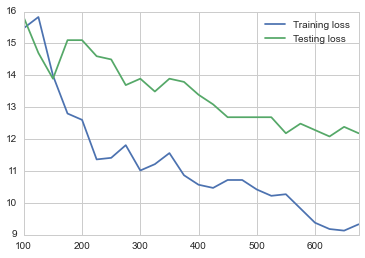

In [128]:
# run KNN for different training set sizes, compare [ loss(train), loss(test) ]
n_training = range(100,y_train.shape[0],25)
knn_performance = pd.DataFrame(index=n_training, columns=['Training loss', 'Testing loss'])
                               
for n in n_training:
    knn = KNeighborsClassifier(n_neighbors=10)
    knn.fit(X_train[:n], y_train[:n])
    
    train_pred = knn.predict(X_train)
    test_pred = knn.predict(X_test)
    
    knn_performance.loc[n] = {'Training loss' : log_loss(y_train, train_pred),
                              'Testing loss' : log_loss(y_test, test_pred)}
    

# plot train v test mmc
knn_performance.plot()

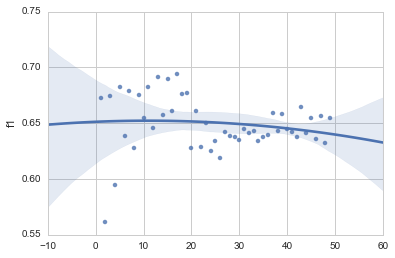

In [129]:
# run KNN for different values of k
k_range = range(1,50)
knn_performance = pd.DataFrame(index=k_range, columns=['f1','precision','recall','accuracy'])
                               
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    knn_performance.loc[k] = {'f1' : f1_score(y_test, y_pred),
                              'precision' : precision_score(y_test, y_pred),
                              'recall' : recall_score(y_test, y_pred),
                              'accuracy' : accuracy_score(y_test, y_pred)}

# add the best scores for the algorithm to the performance dataframe
algorithm_performance.loc['k-Nearest Neighbors'] = {col_name : np.max(col) 
                                                    for col_name, col in 
                                                    knn_performance.transpose().iterrows()}

# plot mcc(k)
knn_plot = sns.regplot(x=knn_performance.index.get_values(), y='f1', data=knn_performance, order=2)


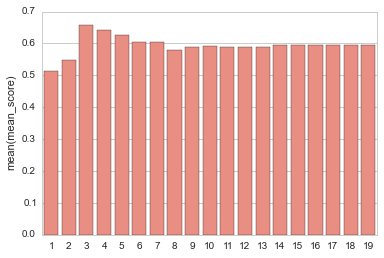

In [130]:
# determine optimal pruning for the decision trees using cross-validation grid-search on max_depth
depth_range = range(1,20)
tree_param_grid = [{'max_depth' : depth_range}]

tree_gs = GridSearchCV(DecisionTreeClassifier(random_state=rand_state),
                       tree_param_grid, cv=3, scoring='f1')

tree_gs.fit(X_train, y_train)

# plot f1 over max_depth
pruning_df = pd.DataFrame(columns=['mean_score','std'])

for params, mean_score, scores in tree_gs.grid_scores_:
    pruning_df.loc[params['max_depth']] = {'mean_score':mean_score, 'std':scores.std()}

sns.barplot(x=pruning_df.index.get_values(), y='mean_score', data=pruning_df, ci='std',color='salmon')        

# save the best tree for further analysis
best_tree = tree_gs.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=<mtrand.RandomState object at 0x111f98d10>,
            splitter='best')

             precision    recall  f1-score   support

          0       0.63      0.47      0.54       164
          1       0.61      0.75      0.67       179

avg / total       0.62      0.62      0.61       343



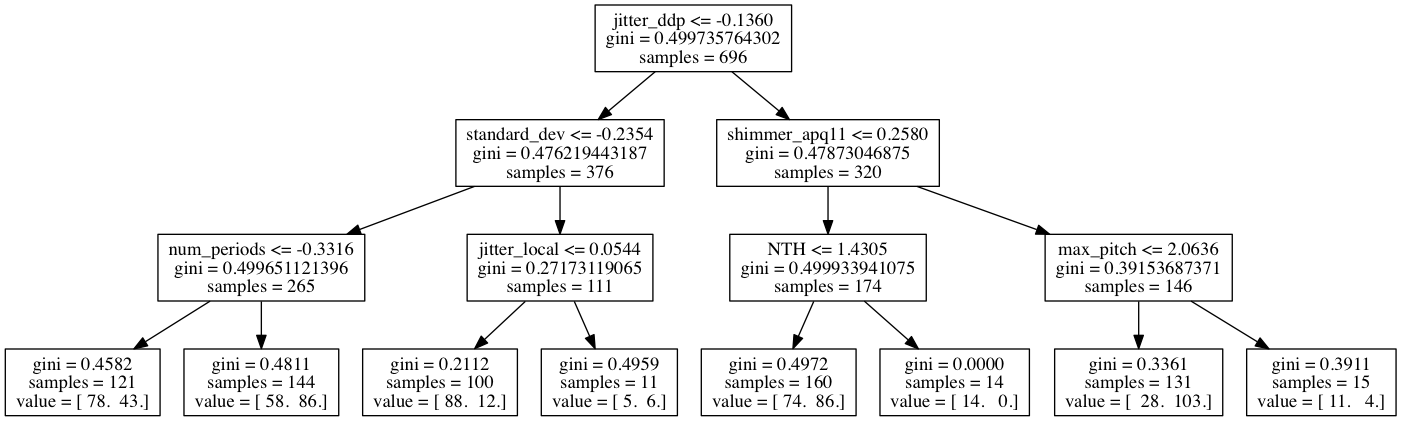

In [131]:
# predict test set labels from attributes
y_pred = best_tree.predict(X_test)

print best_tree
print
print classification_report(y_test, y_pred)

# add the best scores for the algorithm to the performance dataframe
algorithm_performance.loc['Decision Tree'] = {'f1' : f1_score(y_test, y_pred),
                              'precision' : precision_score(y_test, y_pred),
                              'recall' : recall_score(y_test, y_pred),
                              'accuracy' : accuracy_score(y_test, y_pred)}

# visualizes the optimal tree
with open('tree.dot', 'w') as dotfile:
    export_graphviz(
        best_tree,
        dotfile,
        feature_names=X_train.columns)
    
subprocess.call(['dot','-Tpng','tree.dot','-o','tree.png'])
Image(filename='tree.png')

In [132]:
# run cross validation w/ grid search over SVM parameters
svm_param_grid = [{'kernel': ['rbf'], 'gamma': np.linspace(1e-2, 1e-3,num=10),
                     'C': range(1,500,50)}]

svm_gs = GridSearchCV(SVC(random_state=rand_state), svm_param_grid,
                       cv=3, scoring='f1')

svm_gs.fit(X_train, y_train)

# save the best tree for further analysis
best_svm = svm_gs.best_estimator_

SVC(C=51, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.002,
  kernel='rbf', max_iter=-1, probability=False,
  random_state=<mtrand.RandomState object at 0x1125dde90>, shrinking=True,
  tol=0.001, verbose=False)

             precision    recall  f1-score   support

          0       0.67      0.61      0.64       164
          1       0.67      0.73      0.70       179

avg / total       0.67      0.67      0.67       343



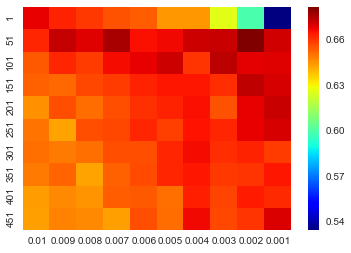

In [133]:
svm_df = pd.DataFrame(columns=svm_param_grid[0]['gamma'],index=svm_param_grid[0]['C'])

for params, mean_score, scores in svm_gs.grid_scores_:
    svm_df.loc[params['C']][params['gamma']] = mean_score

sns.heatmap(svm_df.fillna(value=0.),cmap="jet")

# predict test set labels from attributes
y_pred = best_svm.predict(X_test)

print best_svm
print
print classification_report(y_test, y_pred)

# add the best scores for the algorithm to the performance dataframe
algorithm_performance.loc['SVM rbf'] = {'f1' : f1_score(y_test, y_pred),
                              'precision' : precision_score(y_test, y_pred),
                              'recall' : recall_score(y_test, y_pred),
                              'accuracy' : accuracy_score(y_test, y_pred)}


In [124]:
# run cross validation w/ grid search over SVM parameters
svm_param_grid = [{'kernel': ['sigmoid'], 'gamma': np.linspace(1e-2, 2e-3,num=10),
                     'coef0': np.linspace(0.0, 0.1,num=10)}]

svm_gs = GridSearchCV(SVC(random_state=rand_state), svm_param_grid,
                       cv=3, scoring='f1')

svm_gs.fit(X_train, y_train)

# save the best tree for further analysis
best_svm = svm_gs.best_estimator_

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.10000000000000001,
  degree=3, gamma=0.01, kernel='sigmoid', max_iter=-1, probability=False,
  random_state=<mtrand.RandomState object at 0x1127b4810>, shrinking=True,
  tol=0.001, verbose=False)

             precision    recall  f1-score   support

          0       0.58      0.48      0.53       165
          1       0.58      0.67      0.62       178

avg / total       0.58      0.58      0.58       343



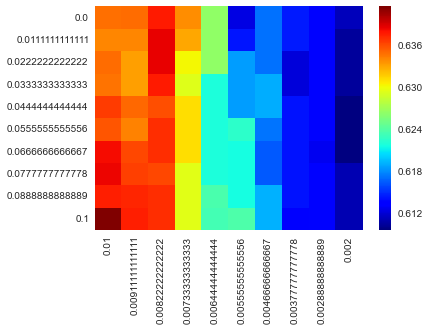

In [125]:
svm_df = pd.DataFrame(columns=svm_param_grid[0]['gamma'],index=svm_param_grid[0]['coef0'])

for params, mean_score, scores in svm_gs.grid_scores_:
    svm_df.loc[params['coef0']][params['gamma']] = mean_score

sns.heatmap(svm_df.fillna(value=0.),cmap="jet")

# predict test set labels from attributes
y_pred = best_svm.predict(X_test)

print best_svm
print
print classification_report(y_test, y_pred)

# add the best scores for the algorithm to the performance dataframe
algorithm_performance.loc['SVM sigmoid'] = {'f1' : f1_score(y_test, y_pred),
                              'precision' : precision_score(y_test, y_pred),
                              'recall' : recall_score(y_test, y_pred),
                              'accuracy' : accuracy_score(y_test, y_pred)}

In [118]:
print algorithm_performance

                            f1  precision     recall   accuracy
k-Nearest Neighbors  0.7220779       0.75  0.7921348  0.6880466
Decision Tree        0.5781711  0.6086957  0.5505618  0.5830904
Boosted Tree               NaN        NaN        NaN        NaN
SVM rbf               0.761658  0.7067308  0.8258427  0.7317784
SVM sigmoid                NaN        NaN        NaN        NaN
Neural Network             NaN        NaN        NaN        NaN


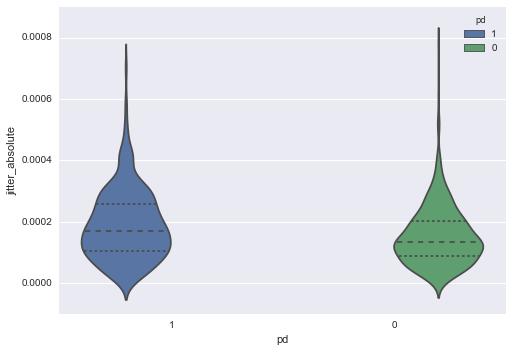

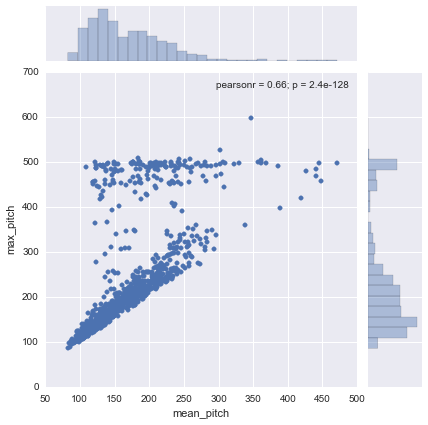

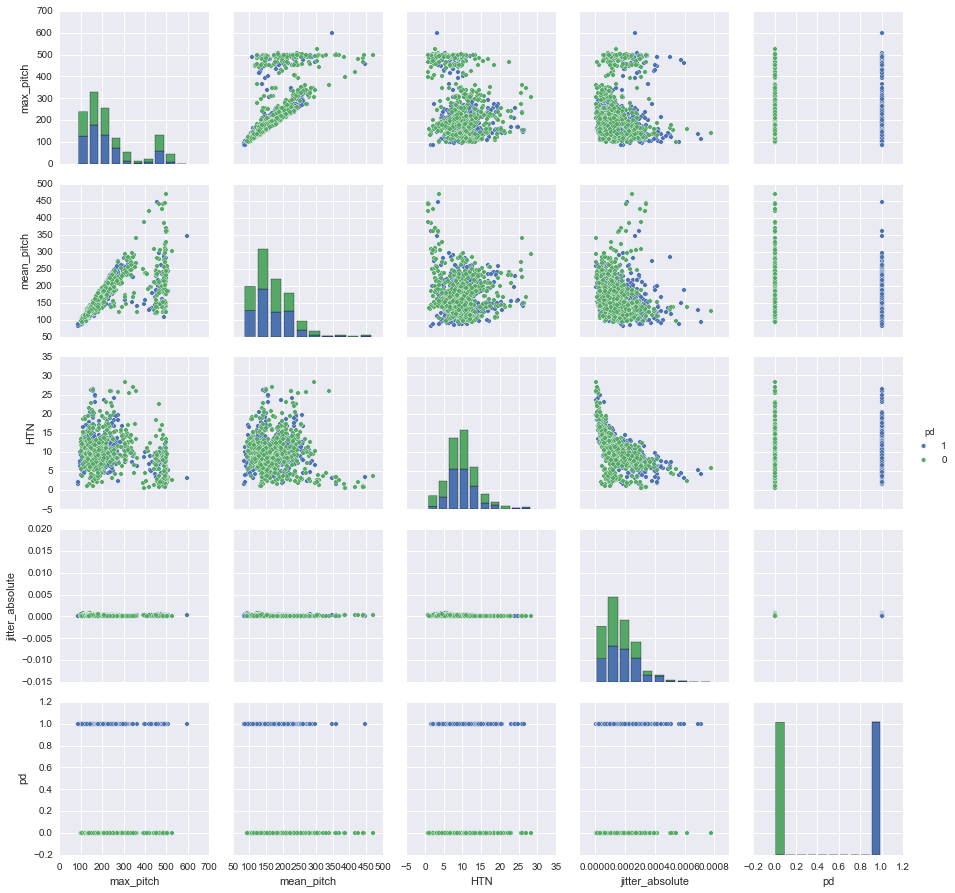

In [7]:
# exploritory / descriptive visualizaitons
sns.violinplot(x='pd',y='jitter_absolute',data=df, hue='pd',inner="quart")
sns.jointplot('mean_pitch','max_pitch',data=df,kind='scatter')
sns.pairplot(df[['max_pitch','mean_pitch','HTN','jitter_absolute','pd']], hue='pd')